# 相鄰兩個session的分布，包含target session的training data(虔320秒)與testing data

device: cuda
if torch.cuda is available: True

 Source Dataset : /home/jovyan/dataset/indy/Sorted_Spike_Dataset/indy_20160420_01.mat

 Source Dataset : /home/jovyan/dataset/indy/Sorted_Spike_Dataset/indy_20160426_01.mat
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 32532 samples in 0.001s...
[t-SNE] Computed neighbors for 32532 samples in 13.236s...
[t-SNE] Computed conditional probabilities for sample 1000 / 32532
[t-SNE] Computed conditional probabilities for sample 2000 / 32532
[t-SNE] Computed conditional probabilities for sample 3000 / 32532
[t-SNE] Computed conditional probabilities for sample 4000 / 32532
[t-SNE] Computed conditional probabilities for sample 5000 / 32532
[t-SNE] Computed conditional probabilities for sample 6000 / 32532
[t-SNE] Computed conditional probabilities for sample 7000 / 32532
[t-SNE] Computed conditional probabilities for sample 8000 / 32532
[t-SNE] Computed conditional probabilities for sample 9000 / 32532
[t-SNE] Computed conditional pro

Text(0, 0.5, 'Feature_2')

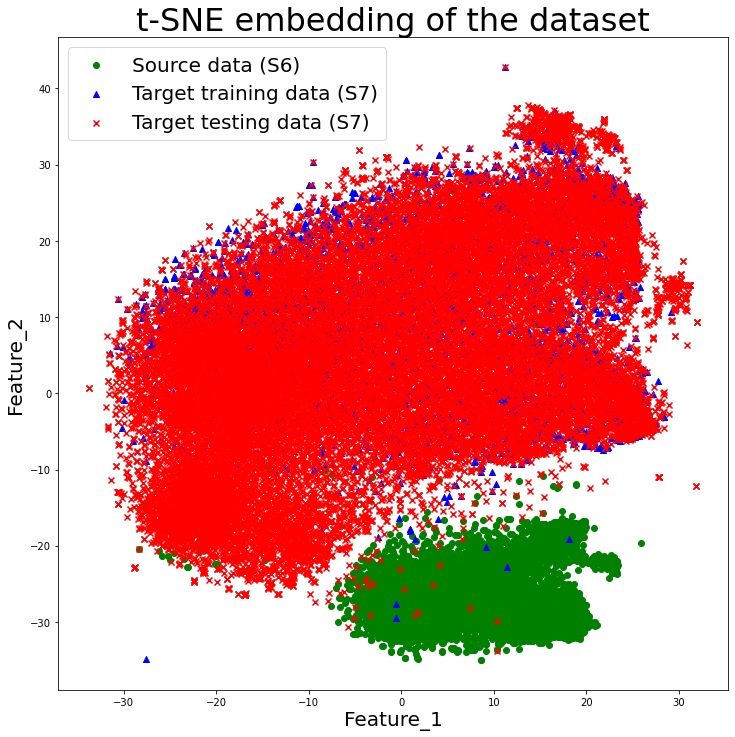

In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Fri Jul 16 16:30:06 2021

@author: ogk
"""

import os
from os import listdir
import pandas
import h5py
import numpy as np
from sklearn import manifold
import torch
import torch.utils.data
import matplotlib.pyplot as plt
# from tsnecuda import TSNE
# embeddedX = TSNE(n_components=2).fit_transform(X)

dataset_path = '/home/jovyan/dataset/indy/Sorted_Spike_Dataset/'
if os.path.isdir(dataset_path) != True:
    print('\n>> Not find dataset folder path: '+dataset_path)
    print('>> Please Check folder_path && Computer working system !\n')
    
# argument setting
bin_width = 16
channel = np.arange(96)+1

# use cuda
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device:', device)
print('if torch.cuda is available:', torch.cuda.is_available())

save_path = '/home/ogk/Documents/OGK/tSNE/source_target/'

fr = []
train_fr = []


def Get_Spike_Firring(firring_point, bins):
        spike_data = []
        time_last_point = bins[-1]
        for i in firring_point:
            if i < time_last_point:
                spike_data.append(i)
        # mapping_data = np.digitize(spike_data, bins)
        map_data, bin_arr = np.histogram(spike_data, bins=bins)
        
        return map_data.reshape(-1, len(map_data))

big_data = np.empty([0, 96])
# 選相鄰的兩個session
sourceSession=6
for s in range(sourceSession, sourceSession+2):

    # init.var
    List_File = listdir(dataset_path)
    List_File.sort()
    file_name = List_File[s-1]
    print('\n Source Dataset :',dataset_path+str(file_name))
    mat_file = h5py.File(dataset_path+str(file_name), 'r') # read mat file
    CHANNELS = mat_file[list(mat_file.keys())[1]] # electric channel Info
    CURSOR_POS = mat_file[list(mat_file.keys())[2]] # cursor position
    FINGER_POS = mat_file[list(mat_file.keys())[3]] # finger position
    SPIKES = mat_file[list(mat_file.keys())[4]] # Spike firing time point 這邊是紀錄發生spike的時間點,所以根據bins寬度,要另外整理
    Session_Unit = SPIKES.shape[0] # session unit count ,此一session有幾個被sorting的unit 第一筆皆為hash
    TIMES = mat_file[list(mat_file.keys())[5]] # session t 0.004=4ms
    time_bin = (TIMES[0])[::bin_width]

    # get firing rate
    search_index = 0
    for ch_index in channel:
        # concat data by channel
        fr_unit_hash = []
        fr_unit_01 = []
        fr_unit_02 = []
        fr_unit_03 = []
        fr_unit_04 = []

        unit_hash = mat_file[SPIKES[0][ch_index-1]] 
        unit_01 = mat_file[SPIKES[1][ch_index-1]]
        unit_02 = mat_file[SPIKES[2][ch_index-1]]

        # unit.shape[0] == 2 ,.mat file show this is null array>>表示 .mat檔對應的是空集合的channel
        if unit_hash.shape[0] != 2 :
            fr_unit_hash = Get_Spike_Firring(unit_hash[0], time_bin)
        else:
            fr_unit_hash = np.zeros([1,time_bin.shape[0]-1])

        if unit_01.shape[0] != 2 :
            fr_unit_01 = Get_Spike_Firring(unit_01[0], time_bin)
        else:
            fr_unit_01 = np.zeros([1,time_bin.shape[0]-1]) 

        if unit_02.shape[0] !=2 :    
            fr_unit_02 = Get_Spike_Firring(unit_02[0], time_bin)
        else:
            fr_unit_02 = np.zeros([1,time_bin.shape[0]-1])

        if Session_Unit == 5:
            unit_03 = mat_file[SPIKES[3][ch_index-1]]
            unit_04 = mat_file[SPIKES[4][ch_index-1]]
            if unit_03.shape[0] !=2 : 
                fr_unit_03 = Get_Spike_Firring(unit_03[0], time_bin)
            else:
                fr_unit_03 = np.zeros([1,time_bin.shape[0]-1])

            if unit_04.shape[0] !=2 :
                fr_unit_04 = Get_Spike_Firring(unit_04[0], time_bin)
            else:
                fr_unit_04 = np.zeros([1,time_bin.shape[0]-1])
        else:
            fr_unit_03 = np.zeros([1,time_bin.shape[0]-1])
            fr_unit_04 = np.zeros([1,time_bin.shape[0]-1])

        # concate unit data
        if search_index == 0:
            Firing_rate_hash = fr_unit_hash
            Firing_rate_unit_1 = fr_unit_01
            Firing_rate_unit_2 = fr_unit_02
            Firing_rate_unit_3 = fr_unit_03
            Firing_rate_unit_4 = fr_unit_04
        else:
            Firing_rate_hash = np.concatenate((Firing_rate_hash, fr_unit_hash), axis=0)
            Firing_rate_unit_1 = np.concatenate((Firing_rate_unit_1, fr_unit_01), axis=0)
            Firing_rate_unit_2 = np.concatenate((Firing_rate_unit_2, fr_unit_02), axis=0)
            Firing_rate_unit_3 = np.concatenate((Firing_rate_unit_3, fr_unit_03), axis=0)
            Firing_rate_unit_4 = np.concatenate((Firing_rate_unit_4, fr_unit_04), axis=0)
        search_index +=1

    # print('=====',np.all(Firing_rate_unit_4 == 0))
    Unsort_data = Firing_rate_hash+ Firing_rate_unit_1+ Firing_rate_unit_2+ Firing_rate_unit_3 +Firing_rate_unit_4
#     print('Unsort Data shape:', np.shape(Unsort_data))
    all_data = np.transpose(Unsort_data)

    if s == sourceSession:
        big_data = all_data[:5000, :]
    else:
        big_data = np.concatenate((big_data, all_data), axis=0)


source = len(big_data)-len(all_data)
target_train = 5000
target_test = len(all_data)-5000
label = np.hstack([source, target_train, target_test])
    # lebel = (s+1)*np.ones((5000))
    # if s == 3:
    #     session_tex = lebel
    # else:
    #     session_tex = np.hstack([session_tex, lebel])

#t-SNE
X_tsne = manifold.TSNE(n_components=2, init='random', perplexity=50, random_state=5, verbose=1, early_exaggeration=20).fit_transform(big_data)

plt.figure(figsize=(12,12))
plt.scatter(X_tsne[:source,0], X_tsne[:source,1], marker='o', color='g', label='Source data (S'+str(sourceSession)+')')
plt.scatter(X_tsne[source+1:source+1+target_train,0], X_tsne[source+1:source+1+target_train,1], marker='^', color='b', label='Target training data (S'+str(sourceSession+1)+')')
plt.scatter(X_tsne[source+2+target_train:,0], X_tsne[source+2+target_train:,1], marker='x', color='r', label='Target testing data (S'+str(sourceSession+1)+')')
plt.title('t-SNE embedding of the dataset', fontsize=32)
plt.legend(fontsize=20)
plt.xlabel('Feature_1', fontsize=20)
plt.ylabel('Feature_2', fontsize=20)

# plt.savefig(save_path+'S'+str(S)+'_T'+str(S+1)+'.png')
# df = pandas.DataFrame(dict(Feature_1=X_tsne[:,0], Feature_2=X_tsne[:,1], label=label))
# df.plot.scatter(x='Feature_1', y='Feature_2', c='label', colormap='viridis', s=5, figsize=(12,10))
# plt.savefig(os.path.splitext(file_name)[0]+'.png')